In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
class ImageEnhancer:
    """Class for enhancing wildfire images to improve model performance"""
    
    @staticmethod
    def adjust_contrast(image, alpha=1.5):
        """Enhance contrast of the image"""
        return np.clip(alpha * image, 0, 1)
    
    @staticmethod
    def adjust_brightness(image, beta=0.1):
        """Adjust brightness of the image"""
        return np.clip(image + beta, 0, 1)
    
    @staticmethod
    def apply_clahe(image):
        """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)"""
        img_yuv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return img_rgb / 255.0
    
    @staticmethod
    def sharpen_image(image):
        """Apply sharpening filter to image"""
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened = cv2.filter2D(image, -1, kernel)
        return np.clip(sharpened, 0, 1)
    
    @staticmethod
    def enhance_fire_colors(image):
        """Enhance red/orange colors typical in wildfire images"""
        # Convert to HSV and amplify red/orange hues
        hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        # Amplify reds and oranges (hue values near 0)
        red_mask = (hsv[:, :, 0] < 30) | (hsv[:, :, 0] > 150)
        hsv[:, :, 1] = np.where(red_mask, np.minimum(hsv[:, :, 1] * 1.5, 255), hsv[:, :, 1])
        enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return enhanced / 255.0
    
    @staticmethod
    def apply_all_enhancements(image):
        """Apply all enhancement techniques"""
        enhanced = ImageEnhancer.adjust_contrast(image)
        enhanced = ImageEnhancer.sharpen_image(enhanced)
        enhanced = ImageEnhancer.enhance_fire_colors(enhanced)
        return enhanced

In [3]:
class WildfireAutoencoder:
    def __init__(self, img_size=64, latent_dim=32):
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.encoder = None
        self.decoder = None
        self.autoencoder = None
        self.classifier = None
        self.class_names = ['nowildfire', 'wildfire']
        
        # Data attributes
        self.x_train = None
        self.y_train = None
        self.x_val = None
        self.y_val = None
        self.x_test = None
        self.y_test = None
        self.class_weights = None
        self.class_weight_dict = None

    def load_and_preprocess_data(self, train_dir, valid_dir, test_dir):
        """Load and preprocess image data from directories"""
        print("Loading and preprocessing data...")
        
        # Load training data
        self.x_train, self.y_train = self._load_images_from_dir(train_dir)
        # Load validation data
        self.x_val, self.y_val = self._load_images_from_dir(valid_dir)
        # Load test data
        self.x_test, self.y_test = self._load_images_from_dir(test_dir)
        
        # Calculate class weights
        self._calculate_class_weights()
        
        print(f"Training data shape: {self.x_train.shape}")
        print(f"Validation data shape: {self.x_val.shape}")
        print(f"Test data shape: {self.x_test.shape}")
        print(f"Class weights: {self.class_weight_dict}")

    def _load_images_from_dir(self, directory):
        """Load images from a directory and preprocess them"""
        images = []
        labels = []
        
        for class_name in self.class_names:
            class_dir = os.path.join(directory, class_name)
            class_idx = self.class_names.index(class_name)
            
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    # Load and resize image
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (self.img_size, self.img_size))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
                    
                    images.append(img)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
        
        # Shuffle data
        indices = np.arange(len(images))
        np.random.shuffle(indices)
        
        return np.array(images)[indices], np.array(labels)[indices]

    def _calculate_class_weights(self):
        """Calculate class weights for imbalanced datasets"""
        self.class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        self.class_weight_dict = {i: weight for i, weight in enumerate(self.class_weights)}

    def load_processed_data(self, directory):
        """Load preprocessed data from disk"""
        print(f"Loading preprocessed data from {directory}...")
        self.x_train = np.load(os.path.join(directory, 'x_train.npy'))
        self.y_train = np.load(os.path.join(directory, 'y_train.npy'))
        self.x_val = np.load(os.path.join(directory, 'x_val.npy'))
        self.y_val = np.load(os.path.join(directory, 'y_val.npy'))
        self.x_test = np.load(os.path.join(directory, 'x_test.npy'))
        self.y_test = np.load(os.path.join(directory, 'y_test.npy'))
        
        # Calculate class weights
        self._calculate_class_weights()
        
        print(f"Data loaded successfully. Shapes: Train={self.x_train.shape}, Val={self.x_val.shape}, Test={self.x_test.shape}")

    def build_autoencoder(self):
        """Build the autoencoder model"""
        input_img = Input(shape=(self.img_size, self.img_size, 3))
        
        # Encoder
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        
        # Calculate shape before flatten
        shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
        
        # Latent space
        x = Flatten()(x)
        encoded = Dense(self.latent_dim, activation='relu')(x)
        
        # Create encoder model
        self.encoder = Model(input_img, encoded, name='encoder')
        
        # Decoder
        latent_input = Input(shape=(self.latent_dim,))
        x = Dense(np.prod(shape_before_flatten), activation='relu')(latent_input)
        x = Reshape(shape_before_flatten)(x)
        
        # Decoder path
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        
        # Create decoder model
        self.decoder = Model(latent_input, decoded, name='decoder')
        
        # Create autoencoder
        self.autoencoder = Model(input_img, self.decoder(self.encoder(input_img)), name='autoencoder')
        self.autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        print("Autoencoder built successfully.")
        print(self.encoder.summary())
        print(self.decoder.summary())

    def build_classifier(self):
        """Build the classifier model using the encoder"""
        if self.encoder is None:
            raise ValueError("Encoder must be built first. Call build_autoencoder() before build_classifier().")
        
        # Create classifier
        input_img = Input(shape=(self.img_size, self.img_size, 3))
        encoded = self.encoder(input_img)
        x = Dense(64, activation='relu')(encoded)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)
        
        self.classifier = Model(input_img, output, name='classifier')
        self.classifier.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        print("Classifier built successfully.")
        print(self.classifier.summary())

    def train_autoencoder(self, epochs=30, batch_size=32):
        """Train the autoencoder"""
        if self.autoencoder is None:
            raise ValueError("Autoencoder not built. Call build_autoencoder() first.")
            
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ModelCheckpoint('autoencoder_best.h5', save_best_only=True)
        ]
        
        print("Training autoencoder...")
        history = self.autoencoder.fit(
            self.x_train, self.x_train,
            validation_data=(self.x_val, self.x_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Autoencoder Training History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
        
        return history

    def train_classifier(self, epochs=30, batch_size=32):
        """Train the classifier"""
        if self.classifier is None:
            raise ValueError("Classifier not built. Call build_classifier() first.")
            
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ModelCheckpoint('classifier_best.h5', save_best_only=True)
        ]
        
        print("Training classifier...")
        history = self.classifier.fit(
            self.x_train, self.y_train,
            validation_data=(self.x_val, self.y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=self.class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Classifier Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Classifier Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return history

    def evaluate_classifier(self):
        """Evaluate the classifier on test data"""
        if self.classifier is None:
            raise ValueError("Classifier not built. Call build_classifier() first.")
            
        print("Evaluating classifier on test set...")
        loss, accuracy = self.classifier.evaluate(self.x_test, self.y_test, verbose=0)
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Loss: {loss:.4f}")
        
        # Get predictions
        y_pred = self.classifier.predict(self.x_test)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        # Display confusion matrix
        cm = confusion_matrix(self.y_test, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Display classification report
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred_classes))
        
        return accuracy

    def save_models(self, directory):
        """Save all models to directory"""
        os.makedirs(directory, exist_ok=True)
        self.encoder.save(os.path.join(directory, 'encoder.h5'))
        self.decoder.save(os.path.join(directory, 'decoder.h5'))
        self.autoencoder.save(os.path.join(directory, 'autoencoder.h5'))
        self.classifier.save(os.path.join(directory, 'classifier.h5'))
        print(f"Models saved to {directory}")

    def load_models(self, directory):
        """Load models from directory"""
        self.encoder = load_model(os.path.join(directory, 'encoder.h5'))
        self.decoder = load_model(os.path.join(directory, 'decoder.h5'))
        self.autoencoder = load_model(os.path.join(directory, 'autoencoder.h5'))
        self.classifier = load_model(os.path.join(directory, 'classifier.h5'))
        print(f"Models loaded from {directory}")

    def visualize_reconstructions(self, num_images=5):
        """Visualize original and reconstructed images"""
        indices = np.random.choice(len(self.x_test), num_images, replace=False)
        test_images = self.x_test[indices]
        reconstructions = self.autoencoder.predict(test_images)
        
        plt.figure(figsize=(10, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(test_images[i])
            plt.title("Original")
            plt.axis('off')
            
            # Reconstructed
            plt.subplot(2, num_images, i + num_images + 1)
            plt.imshow(reconstructions[i])
            plt.title("Reconstructed")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    def build_ensemble(self, num_models=3):
        """Build multiple classifier models for ensembling"""
        if self.encoder is None:
            raise ValueError("Encoder must be built first. Call build_autoencoder() before build_ensemble().")
        
        self.ensemble_models = []
        
        print(f"Building ensemble of {num_models} classifiers...")
        for i in range(num_models):
            # Create classifier with slightly different architecture
            input_img = Input(shape=(self.img_size, self.img_size, 3))
            encoded = self.encoder(input_img)
            
            # Vary the architecture slightly for each ensemble member
            x = Dense(64 + i*16, activation='relu')(encoded)
            x = Dropout(0.4 + i*0.1)(x)  # Different dropout rates
            output = Dense(1, activation='sigmoid')(x)
            
            model = Model(input_img, output, name=f'classifier_{i}')
            model.compile(
                optimizer=Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            self.ensemble_models.append(model)
            print(f"Built ensemble model {i+1}/{num_models}")
        
        print("Ensemble built successfully.")

    def train_ensemble(self, epochs=30, batch_size=32):
        """Train all models in the ensemble"""
        if not hasattr(self, 'ensemble_models') or not self.ensemble_models:
            raise ValueError("Ensemble not built. Call build_ensemble() first.")
        
        histories = []
        import time
        timestamp = int(time.time())  # Add a timestamp to make filenames unique
        
        for i, model in enumerate(self.ensemble_models):
            print(f"Training ensemble model {i+1}/{len(self.ensemble_models)}...")
            
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                ModelCheckpoint(f'ensemble_model_{i}_{timestamp}_best.h5', save_best_only=True)
            ]
            
            # Fix: Use model instead of variable name model (which doesn't exist)
            history = model.fit(  # <-- This was the issue
                self.x_train, self.y_train,
                validation_data=(self.x_val, self.y_val),
                epochs=epochs,
                batch_size=batch_size,
                class_weight=self.class_weight_dict,
                callbacks=callbacks,
                verbose=1
            )
            
            histories.append(history)
        
        return histories
    def ensemble_predict(self, x, method='voting'):
        """Make predictions using the ensemble
        
        Parameters:
        -----------
        x : array
            Input images to predict on
        method : str
            Ensembling method: 'voting', 'averaging', or 'weighted'
        
        Returns:
        --------
        predictions : array
            Ensemble predictions
        """
        if not hasattr(self, 'ensemble_models') or not self.ensemble_models:
            raise ValueError("Ensemble not built. Call build_ensemble() first.")
        
        all_predictions = []
        
        # Get predictions from all models
        for model in self.ensemble_models:
            preds = model.predict(x)
            all_predictions.append(preds)
        
        all_predictions = np.array(all_predictions)
        
        # Apply ensembling method
        if method == 'voting':
            # Hard voting (majority)
            binary_preds = (all_predictions > 0.5).astype(int)
            ensemble_preds = np.mean(binary_preds, axis=0) > 0.5
            return ensemble_preds.astype(float)
        
        elif method == 'averaging':
            # Soft voting (average probabilities)
            return np.mean(all_predictions, axis=0)
        
        elif method == 'weighted':
            # Use validation accuracy as weights
            weights = []
            for model in self.ensemble_models:
                _, val_acc = model.evaluate(self.x_val, self.y_val, verbose=0)
                weights.append(val_acc)
            
            # Normalize weights
            weights = np.array(weights) / np.sum(weights)
            
            # Apply weights to predictions
            weighted_preds = np.zeros_like(all_predictions[0])
            for i, preds in enumerate(all_predictions):
                weighted_preds += weights[i] * preds
            
            return weighted_preds
        
        else:
            raise ValueError("Method must be 'voting', 'averaging', or 'weighted'")

    def evaluate_ensemble(self, method='averaging'):
        """Evaluate the ensemble on test data"""
        if not hasattr(self, 'ensemble_models') or not self.ensemble_models:
            raise ValueError("Ensemble not built. Call build_ensemble() first.")
        
        print(f"Evaluating ensemble using {method} method...")
        
        # Get ensemble predictions
        y_pred = self.ensemble_predict(self.x_test, method=method)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        # Calculate accuracy
        accuracy = accuracy_score(self.y_test, y_pred_classes)
        print(f"Ensemble Test Accuracy: {accuracy:.4f}")
        
        # Display confusion matrix
        cm = confusion_matrix(self.y_test, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Ensemble Confusion Matrix ({method})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Display classification report
        print("\nEnsemble Classification Report:")
        print(classification_report(self.y_test, y_pred_classes))
        
        return accuracy

    def save_ensemble(self, directory):
        """Save all ensemble models to directory"""
        if not hasattr(self, 'ensemble_models') or not self.ensemble_models:
            raise ValueError("Ensemble not built. Call build_ensemble() first.")
        
         
        ensemble_dir = os.path.join(directory, 'ensemble')
        os.makedirs(ensemble_dir, exist_ok=True)
        
        for i, model in enumerate(self.ensemble_models):
            model.save(os.path.join(ensemble_dir, f'ensemble_model_{i}.h5'))
        
        print(f"Ensemble models saved to {ensemble_dir}")

    def load_ensemble(self, directory, num_models):
        """Load ensemble models from directory"""
        ensemble_dir = os.path.join(directory, 'ensemble')
        self.ensemble_models = []
        
        for i in range(num_models):
            model_path = os.path.join(ensemble_dir, f'ensemble_model_{i}.h5')
            if os.path.exists(model_path):
                self.ensemble_models.append(load_model(model_path))
        
        print(f"Loaded {len(self.ensemble_models)} ensemble models from {ensemble_dir}")

In [4]:
# Define data paths (replace with your actual paths)
data_root = "archive"  # Replace with your dataset path
train_dir = r"C:\Users\shash\Downloads\archive\valid"
valid_dir = r"C:\Users\shash\Downloads\archive\valid"
test_dir =  r"C:\Users\shash\Downloads\archive\test"

# Create model instance
model = WildfireAutoencoder(img_size=64, latent_dim=32)
print("WildfireAutoencoder model initialized")

WildfireAutoencoder model initialized


Loading and preprocessing data...
Training data shape: (6300, 64, 64, 3)
Validation data shape: (6300, 64, 64, 3)
Test data shape: (6300, 64, 64, 3)
Class weights: {0: np.float64(1.1170212765957446), 1: np.float64(0.9051724137931034)}


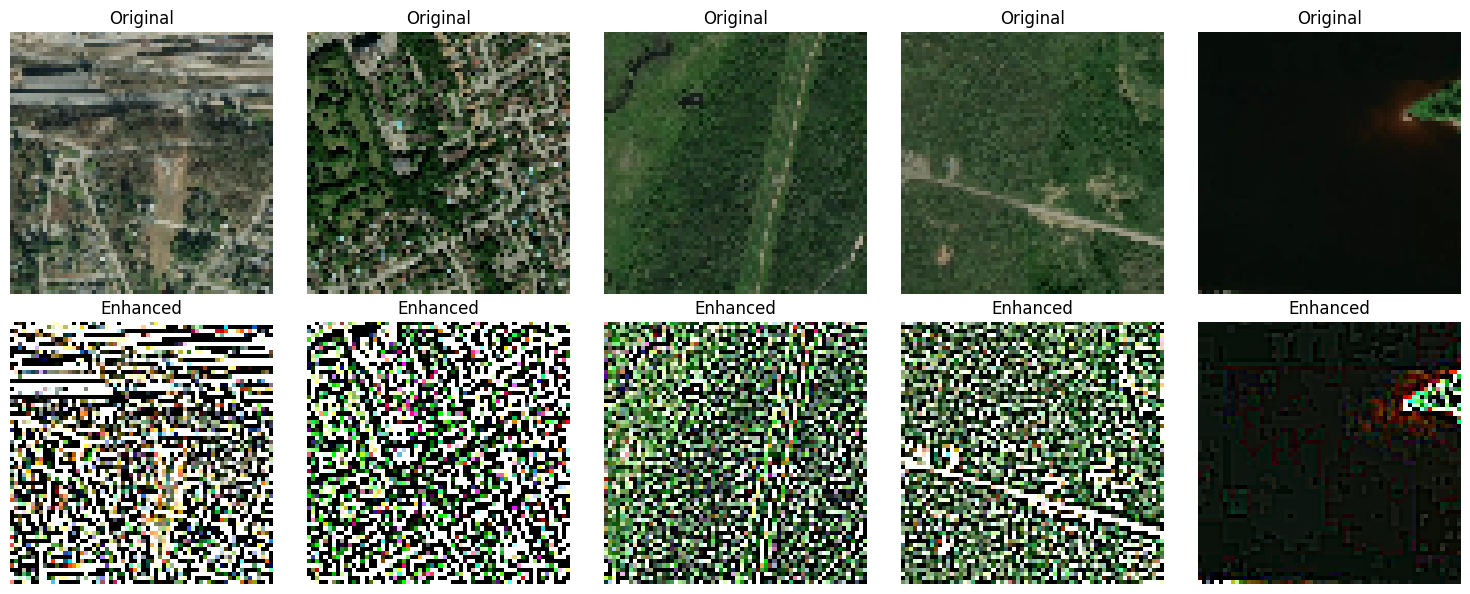

In [5]:
# Either load raw data and preprocess
model.load_and_preprocess_data(train_dir, valid_dir, test_dir)

# OR load already preprocessed data (comment one of these sections)
# preprocessed_data_dir = "preprocessed_data"
# model.load_processed_data(preprocessed_data_dir)

# Apply image enhancement to training data (optional)
enhanced_x_train = np.array([ImageEnhancer.apply_all_enhancements(img) for img in model.x_train])

# Display a few original and enhanced images to compare
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    idx = np.random.randint(0, len(model.x_train))
    axes[0, i].imshow(model.x_train[idx])
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(enhanced_x_train[idx])
    axes[1, i].set_title("Enhanced")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Optional: Replace original training data with enhanced data
# model.x_train = enhanced_x_train

In [6]:
# Cell 3: Build the autoencoder model
autoencoder = model.build_autoencoder()
print(f"Autoencoder architecture created with latent dimension: {model.latent_dim}")
print("Encoder summary:")
model.encoder.summary()
print("\nDecoder summary:")
model.decoder.summary()

Autoencoder built successfully.


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,424 (732.12 KB)

 Trainable params: 187,424 (732.12 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,355 (892.01 KB)

 Trainable params: 228,355 (892.01 KB)

 Non-trainable params: 0 (0.00 B)

None
Autoencoder architecture created with latent dimension: 32
Encoder summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,424 (732.12 KB)

 Trainable params: 187,424 (732.12 KB)

 Non-trainable params: 0 (0.00 B)


Decoder summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,355 (892.01 KB)

 Trainable params: 228,355 (892.01 KB)

 Non-trainable params: 0 (0.00 B)

Training autoencoder...
Epoch 1/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0327

197/197 ━━━━━━━━━━━━━━━━━━━━ 102s 493ms/step - loss: 0.0327 - val_loss: 0.0165
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0158

197/197 ━━━━━━━━━━━━━━━━━━━━ 72s 363ms/step - loss: 0.0158 - val_loss: 0.0154
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0152

197/197 ━━━━━━━━━━━━━━━━━━━━ 66s 335ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 4/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0149

197/197 ━━━━━━━━━━━━━━━━━━━━ 74s 375ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 5/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.0143

197/197 ━━━━━━━━━━━━━━━━━━━━ 72s 365ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 63s 318ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 7/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0139

197/197 ━━━━━━━━━━━━━━━━━━━━ 35s 180ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 8/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0138

197/197 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 9/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0136

197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 173ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 10/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 33s 167ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 11/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0136

197/197 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 12/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0137

197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 173ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 13/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 14/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 35s 177ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 15/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0136

197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 171ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 16/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0137

197/197 ━━━━━━━━━━━━━━━━━━━━ 35s 176ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 17/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 35s 180ms/step - loss: 0.0134 - val_loss: 0.0136
Epoch 18/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0136

197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 173ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 19/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 0.0132 - val_loss: 0.0135
Epoch 20/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0133

197/197 ━━━━━━━━━━━━━━━━━━━━ 33s 169ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 21/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0135

197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 22/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 33s 167ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 23/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0135

197/197 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 24/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0132

197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - loss: 0.0132 - val_loss: 0.0134
Epoch 25/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0133

197/197 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 26/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 172ms/step - loss: 0.0132 - val_loss: 0.0134
Epoch 27/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 28/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0132

197/197 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 29/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - loss: 0.0132 - val_loss: 0.0134
Epoch 30/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - loss: 0.0135 - val_loss: 0.0133


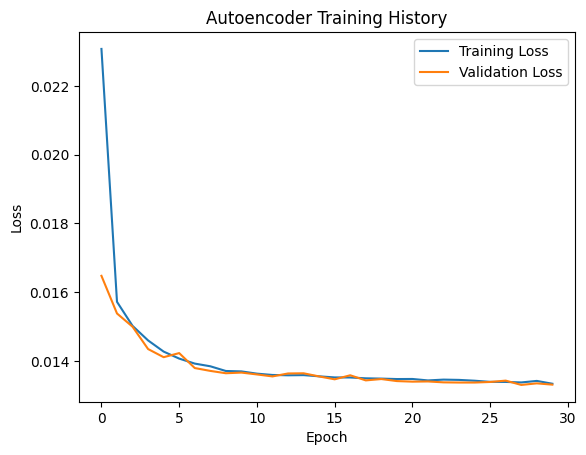

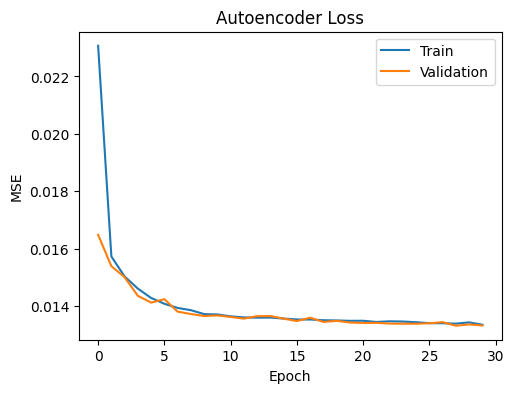

In [7]:
# Train the autoencoder
autoencoder_history = model.train_autoencoder(epochs=30, batch_size=32)
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(autoencoder_history.history['loss'])
plt.plot(autoencoder_history.history['val_loss'])
plt.title('Autoencoder Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Classifier built successfully.


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       187,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,601 (740.63 KB)

 Trainable params: 189,601 (740.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Training classifier...
Epoch 1/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7242 - loss: 0.5605

197/197 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.7247 - loss: 0.5599 - val_accuracy: 0.9097 - val_loss: 0.2238
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8998 - loss: 0.2568

197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.8998 - loss: 0.2568 - val_accuracy: 0.9192 - val_loss: 0.1967
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.9138 - loss: 0.2269 - val_accuracy: 0.9124 - val_loss: 0.2171
Epoch 4/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.9213 - loss: 0.2057 - val_accuracy: 0.8937 - val_loss: 0.2560
Epoch 5/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9120 - loss: 0.2115

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9121 - loss: 0.2113 - val_accuracy: 0.9276 - val_loss: 0.1768
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9281 - loss: 0.1853

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9281 - loss: 0.1853 - val_accuracy: 0.9410 - val_loss: 0.1518
Epoch 7/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9394 - loss: 0.1684

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9394 - loss: 0.1684 - val_accuracy: 0.9444 - val_loss: 0.1400
Epoch 8/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9406 - loss: 0.1553

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9406 - loss: 0.1553 - val_accuracy: 0.9497 - val_loss: 0.1352
Epoch 9/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9456 - loss: 0.1527

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9456 - loss: 0.1527 - val_accuracy: 0.9511 - val_loss: 0.1288
Epoch 10/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9392 - loss: 0.1613

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.9393 - loss: 0.1613 - val_accuracy: 0.9525 - val_loss: 0.1260
Epoch 11/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9483 - loss: 0.1389 - val_accuracy: 0.9527 - val_loss: 0.1266
Epoch 12/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9550 - loss: 0.1273

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9549 - loss: 0.1274 - val_accuracy: 0.9576 - val_loss: 0.1138
Epoch 13/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9544 - loss: 0.1339 - val_accuracy: 0.9568 - val_loss: 0.1145
Epoch 14/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9508 - loss: 0.1243

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.9508 - loss: 0.1243 - val_accuracy: 0.9562 - val_loss: 0.1115
Epoch 15/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9548 - loss: 0.1251 - val_accuracy: 0.9479 - val_loss: 0.1384
Epoch 16/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9529 - loss: 0.1294

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.9530 - loss: 0.1293 - val_accuracy: 0.9624 - val_loss: 0.1046
Epoch 17/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9651 - loss: 0.1084

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9651 - loss: 0.1085 - val_accuracy: 0.9619 - val_loss: 0.0996
Epoch 18/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9632 - loss: 0.1013 - val_accuracy: 0.9633 - val_loss: 0.1033
Epoch 19/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9578 - loss: 0.1150

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9578 - loss: 0.1150 - val_accuracy: 0.9649 - val_loss: 0.0935
Epoch 20/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9607 - loss: 0.1100 - val_accuracy: 0.9535 - val_loss: 0.1252
Epoch 21/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9615 - loss: 0.1097

197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9615 - loss: 0.1097 - val_accuracy: 0.9675 - val_loss: 0.0883
Epoch 22/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9635 - loss: 0.1037

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9635 - loss: 0.1038 - val_accuracy: 0.9673 - val_loss: 0.0876
Epoch 23/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9644 - loss: 0.0981 - val_accuracy: 0.9675 - val_loss: 0.0879
Epoch 24/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9643 - loss: 0.0978

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9643 - loss: 0.0978 - val_accuracy: 0.9698 - val_loss: 0.0837
Epoch 25/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9667 - loss: 0.0966

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9667 - loss: 0.0966 - val_accuracy: 0.9689 - val_loss: 0.0818
Epoch 26/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9648 - loss: 0.0873

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9648 - loss: 0.0873 - val_accuracy: 0.9751 - val_loss: 0.0787
Epoch 27/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9687 - loss: 0.0939 - val_accuracy: 0.9625 - val_loss: 0.0938
Epoch 28/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9704 - loss: 0.0864

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9704 - loss: 0.0864 - val_accuracy: 0.9740 - val_loss: 0.0739
Epoch 29/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9653 - loss: 0.0969

197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.9654 - loss: 0.0968 - val_accuracy: 0.9743 - val_loss: 0.0732
Epoch 30/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9694 - loss: 0.0825

197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.9695 - loss: 0.0825 - val_accuracy: 0.9756 - val_loss: 0.0699


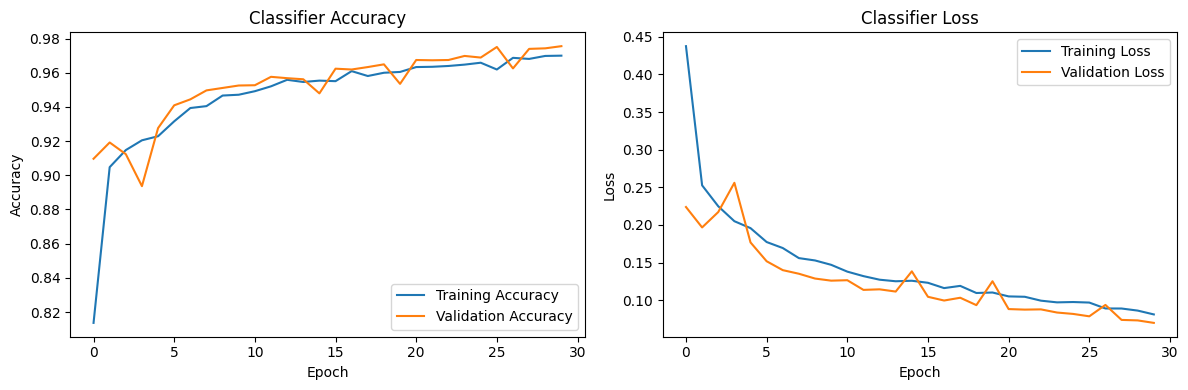

In [8]:
# Build the classifier 
model.build_classifier()

# Train the classifier
classifier_history = model.train_classifier(epochs=30, batch_size=32)

Evaluating classifier on test set...
Test Accuracy: 0.9616
Test Loss: 0.1114
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


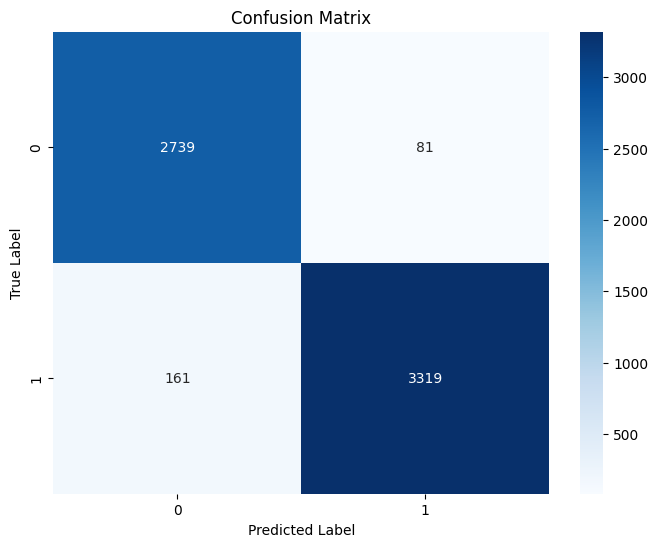


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2820
           1       0.98      0.95      0.96      3480

    accuracy                           0.96      6300
   macro avg       0.96      0.96      0.96      6300
weighted avg       0.96      0.96      0.96      6300

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


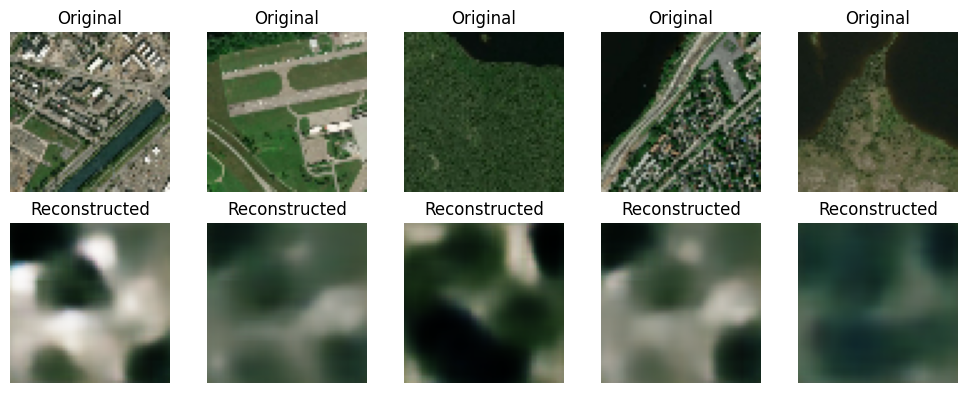

Models saved to trained_models


In [9]:
# Evaluate classifier on test data
model.evaluate_classifier()

# Visualize reconstructions
model.visualize_reconstructions(num_images=5)

# Save the trained models
model.save_models("trained_models")

In [10]:
from tensorflow.keras.models import load_model
import os

def load_models(model, directory):
    """Load models from directory into an instance"""
    model.encoder = load_model(os.path.join(directory, 'encoder.h5'), compile=False)
    model.decoder = load_model(os.path.join(directory, 'decoder.h5'), compile=False)
    model.autoencoder = load_model(os.path.join(directory, 'autoencoder.h5'), compile=False)
    model.classifier = load_model(os.path.join(directory, 'classifier.h5'), compile=False)
    print(f"Models loaded from {directory}")

load_models(model,'trained_models')


Models loaded from trained_models


In [11]:
# First build and train your ensemble
model.build_ensemble(num_models=3)
model.train_ensemble()

# Then save the ensemble to a specific folder
ensemble_folder = "wildfire_ensemble_models"
model.save_ensemble(ensemble_folder)

Building ensemble of 3 classifiers...
Built ensemble model 1/3
Built ensemble model 2/3
Built ensemble model 3/3
Ensemble built successfully.
Training ensemble model 1/3...
Epoch 1/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7983 - loss: 0.4521

197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.7992 - loss: 0.4504 - val_accuracy: 0.9503 - val_loss: 0.1284
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9406 - loss: 0.1550

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9407 - loss: 0.1550 - val_accuracy: 0.9614 - val_loss: 0.1062
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.9520 - loss: 0.1381 - val_accuracy: 0.9584 - val_loss: 0.1075
Epoch 4/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9547 - loss: 0.1237

197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9547 - loss: 0.1237 - val_accuracy: 0.9651 - val_loss: 0.0951
Epoch 5/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9619 - loss: 0.1099 - val_accuracy: 0.9646 - val_loss: 0.0957
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9656 - loss: 0.0988

197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9656 - loss: 0.0988 - val_accuracy: 0.9675 - val_loss: 0.0866
Epoch 7/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9657 - loss: 0.1018

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.9657 - loss: 0.1018 - val_accuracy: 0.9710 - val_loss: 0.0806
Epoch 8/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9644 - loss: 0.1033

197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9644 - loss: 0.1032 - val_accuracy: 0.9727 - val_loss: 0.0783
Epoch 9/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9654 - loss: 0.0933 - val_accuracy: 0.9702 - val_loss: 0.0806
Epoch 10/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9659 - loss: 0.1060

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9659 - loss: 0.1059 - val_accuracy: 0.9735 - val_loss: 0.0754
Epoch 11/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9702 - loss: 0.0866 - val_accuracy: 0.9670 - val_loss: 0.0855
Epoch 12/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9725 - loss: 0.0789

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9725 - loss: 0.0789 - val_accuracy: 0.9751 - val_loss: 0.0712
Epoch 13/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9774 - loss: 0.0725 - val_accuracy: 0.9749 - val_loss: 0.0729
Epoch 14/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9715 - loss: 0.0827

197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.9715 - loss: 0.0826 - val_accuracy: 0.9741 - val_loss: 0.0694
Epoch 15/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9722 - loss: 0.0724 - val_accuracy: 0.9737 - val_loss: 0.0697
Epoch 16/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9755 - loss: 0.0719

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9755 - loss: 0.0719 - val_accuracy: 0.9816 - val_loss: 0.0584
Epoch 17/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9761 - loss: 0.0732 - val_accuracy: 0.9765 - val_loss: 0.0648
Epoch 18/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9778 - loss: 0.0707

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9778 - loss: 0.0707 - val_accuracy: 0.9808 - val_loss: 0.0564
Epoch 19/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9801 - loss: 0.0580

197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9801 - loss: 0.0580 - val_accuracy: 0.9825 - val_loss: 0.0555
Epoch 20/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9828 - loss: 0.0568

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9828 - loss: 0.0569 - val_accuracy: 0.9846 - val_loss: 0.0502
Epoch 21/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9818 - loss: 0.0530 - val_accuracy: 0.9773 - val_loss: 0.0636
Epoch 22/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9783 - loss: 0.0606 - val_accuracy: 0.9833 - val_loss: 0.0536
Epoch 23/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9801 - loss: 0.0601 - val_accuracy: 0.9830 - val_loss: 0.0505
Epoch 24/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0534

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9824 - loss: 0.0534 - val_accuracy: 0.9841 - val_loss: 0.0487
Epoch 25/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9831 - loss: 0.0572

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9831 - loss: 0.0572 - val_accuracy: 0.9875 - val_loss: 0.0417
Epoch 26/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9833 - loss: 0.0496 - val_accuracy: 0.9838 - val_loss: 0.0505
Epoch 27/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9839 - loss: 0.0471

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9839 - loss: 0.0471 - val_accuracy: 0.9890 - val_loss: 0.0373
Epoch 28/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9824 - loss: 0.0478

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9824 - loss: 0.0478 - val_accuracy: 0.9897 - val_loss: 0.0358
Epoch 29/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.9871 - loss: 0.0410 - val_accuracy: 0.9743 - val_loss: 0.0635
Epoch 30/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9837 - loss: 0.0471 - val_accuracy: 0.9800 - val_loss: 0.0487
Training ensemble model 2/3...
Epoch 1/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7355 - loss: 0.4877

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.7367 - loss: 0.4859 - val_accuracy: 0.9616 - val_loss: 0.1097
Epoch 2/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9492 - loss: 0.1492

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9492 - loss: 0.1491 - val_accuracy: 0.9649 - val_loss: 0.0988
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1174

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9581 - loss: 0.1174 - val_accuracy: 0.9748 - val_loss: 0.0776
Epoch 4/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9682 - loss: 0.0936 - val_accuracy: 0.9678 - val_loss: 0.0835
Epoch 5/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9729 - loss: 0.0870

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9729 - loss: 0.0870 - val_accuracy: 0.9805 - val_loss: 0.0634
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9756 - loss: 0.0797 - val_accuracy: 0.9773 - val_loss: 0.0649
Epoch 7/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9739 - loss: 0.0817

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9739 - loss: 0.0817 - val_accuracy: 0.9786 - val_loss: 0.0612
Epoch 8/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9749 - loss: 0.0745

197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9749 - loss: 0.0745 - val_accuracy: 0.9835 - val_loss: 0.0543
Epoch 9/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9779 - loss: 0.0668 - val_accuracy: 0.9690 - val_loss: 0.0832
Epoch 10/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9717 - loss: 0.0760

197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9718 - loss: 0.0759 - val_accuracy: 0.9833 - val_loss: 0.0489
Epoch 11/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9791 - loss: 0.0612

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.9791 - loss: 0.0612 - val_accuracy: 0.9856 - val_loss: 0.0454
Epoch 12/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9810 - loss: 0.0595

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9810 - loss: 0.0595 - val_accuracy: 0.9863 - val_loss: 0.0413
Epoch 13/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9859 - loss: 0.0515

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9859 - loss: 0.0515 - val_accuracy: 0.9871 - val_loss: 0.0396
Epoch 14/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9840 - loss: 0.0480 - val_accuracy: 0.9849 - val_loss: 0.0421
Epoch 15/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9855 - loss: 0.0445

197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.9855 - loss: 0.0445 - val_accuracy: 0.9886 - val_loss: 0.0368
Epoch 16/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9890 - loss: 0.0442

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9890 - loss: 0.0442 - val_accuracy: 0.9917 - val_loss: 0.0319
Epoch 17/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9878 - loss: 0.0374 - val_accuracy: 0.9810 - val_loss: 0.0516
Epoch 18/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9852 - loss: 0.0455 - val_accuracy: 0.9814 - val_loss: 0.0492
Epoch 19/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9881 - loss: 0.0448

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9881 - loss: 0.0447 - val_accuracy: 0.9914 - val_loss: 0.0277
Epoch 20/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9879 - loss: 0.0340

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9879 - loss: 0.0340 - val_accuracy: 0.9933 - val_loss: 0.0262
Epoch 21/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9900 - loss: 0.0347

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9900 - loss: 0.0347 - val_accuracy: 0.9932 - val_loss: 0.0240
Epoch 22/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9883 - loss: 0.0347

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.9883 - loss: 0.0347 - val_accuracy: 0.9941 - val_loss: 0.0223
Epoch 23/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9926 - loss: 0.0298

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9926 - loss: 0.0298 - val_accuracy: 0.9956 - val_loss: 0.0216
Epoch 24/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9909 - loss: 0.0283 - val_accuracy: 0.9784 - val_loss: 0.0496
Epoch 25/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9879 - loss: 0.0416

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9879 - loss: 0.0415 - val_accuracy: 0.9965 - val_loss: 0.0177
Epoch 26/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9910 - loss: 0.0301

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9910 - loss: 0.0301 - val_accuracy: 0.9962 - val_loss: 0.0170
Epoch 27/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9926 - loss: 0.0254

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9926 - loss: 0.0255 - val_accuracy: 0.9965 - val_loss: 0.0164
Epoch 28/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9937 - loss: 0.0247

197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9937 - loss: 0.0247 - val_accuracy: 0.9960 - val_loss: 0.0153
Epoch 29/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9938 - loss: 0.0202 - val_accuracy: 0.9873 - val_loss: 0.0318
Epoch 30/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9958 - loss: 0.0195 - val_accuracy: 0.9908 - val_loss: 0.0261
Training ensemble model 3/3...
Epoch 1/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7817 - loss: 0.4515

197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.7822 - loss: 0.4507 - val_accuracy: 0.9652 - val_loss: 0.1014
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9475 - loss: 0.1427

197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9475 - loss: 0.1427 - val_accuracy: 0.9732 - val_loss: 0.0817
Epoch 3/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9602 - loss: 0.1043

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9602 - loss: 0.1042 - val_accuracy: 0.9765 - val_loss: 0.0618
Epoch 4/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9703 - loss: 0.0907

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9703 - loss: 0.0906 - val_accuracy: 0.9781 - val_loss: 0.0604
Epoch 5/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9755 - loss: 0.0777

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9755 - loss: 0.0777 - val_accuracy: 0.9862 - val_loss: 0.0465
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9781 - loss: 0.0657 - val_accuracy: 0.9805 - val_loss: 0.0523
Epoch 7/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9790 - loss: 0.0593 - val_accuracy: 0.9675 - val_loss: 0.0812
Epoch 8/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9843 - loss: 0.0573

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.9843 - loss: 0.0572 - val_accuracy: 0.9846 - val_loss: 0.0418
Epoch 9/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9836 - loss: 0.0527

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9836 - loss: 0.0527 - val_accuracy: 0.9856 - val_loss: 0.0417
Epoch 10/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9851 - loss: 0.0471

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9851 - loss: 0.0471 - val_accuracy: 0.9840 - val_loss: 0.0407
Epoch 11/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9856 - loss: 0.0426

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9856 - loss: 0.0426 - val_accuracy: 0.9935 - val_loss: 0.0259
Epoch 12/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9858 - loss: 0.0394

197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9858 - loss: 0.0394 - val_accuracy: 0.9929 - val_loss: 0.0249
Epoch 13/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9891 - loss: 0.0351 - val_accuracy: 0.9846 - val_loss: 0.0398
Epoch 14/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9908 - loss: 0.0345 - val_accuracy: 0.9773 - val_loss: 0.0531
Epoch 15/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9879 - loss: 0.0345

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.9879 - loss: 0.0345 - val_accuracy: 0.9933 - val_loss: 0.0203
Epoch 16/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9920 - loss: 0.0271

197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9920 - loss: 0.0271 - val_accuracy: 0.9943 - val_loss: 0.0184
Epoch 17/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9912 - loss: 0.0301 - val_accuracy: 0.9916 - val_loss: 0.0212
Epoch 18/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9926 - loss: 0.0262 - val_accuracy: 0.9932 - val_loss: 0.0240
Epoch 19/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9958 - loss: 0.0210

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9958 - loss: 0.0211 - val_accuracy: 0.9952 - val_loss: 0.0178
Epoch 20/30
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9883 - loss: 0.0359

197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.9883 - loss: 0.0359 - val_accuracy: 0.9973 - val_loss: 0.0136
Epoch 21/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.9962 - loss: 0.0186 - val_accuracy: 0.9959 - val_loss: 0.0143
Epoch 22/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.9945 - loss: 0.0199 - val_accuracy: 0.9954 - val_loss: 0.0178
Epoch 23/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9952 - loss: 0.0194 - val_accuracy: 0.9962 - val_loss: 0.0139
Epoch 24/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.9950 - loss: 0.0158 - val_accuracy: 0.9956 - val_loss: 0.0157
Epoch 25/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9935 - loss: 0.0196 - val_accuracy: 0.9919 - val_loss: 0.0212


Ensemble models saved to wildfire_ensemble_models\ensemble


In [12]:
# To load the models back
model.load_ensemble(ensemble_folder, num_models=3)

Loaded 3 ensemble models from wildfire_ensemble_models\ensemble


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def compare_all_models_external(model):
    """External version of compare_all_models() that works on any WildfireAutoencoder instance"""
    try:
        # Verify test data exists
        if not hasattr(model, 'x_test') or model.x_test is None:
            raise ValueError("Test data not loaded. Call load_processed_data() or load_and_preprocess_data() first.")

        results = {}

        # 1. Evaluate base classifier
        if hasattr(model, 'classifier') and model.classifier:
            print("\nEvaluating base classifier...")
            y_pred = model.classifier.predict(model.x_test)
            y_pred_classes = (y_pred > 0.5).astype(int)
            
            results['Base Classifier'] = {
                'accuracy': accuracy_score(model.y_test, y_pred_classes),
                'precision': precision_score(model.y_test, y_pred_classes),
                'recall': recall_score(model.y_test, y_pred_classes),
                'f1': f1_score(model.y_test, y_pred_classes)
            }

        # 2. Evaluate ensemble models (if they exist)
        if hasattr(model, 'ensemble_models') and model.ensemble_models:
            print("\nEvaluating ensemble models...")
            for i, ensemble_model in enumerate(model.ensemble_models):
                y_pred = ensemble_model.predict(model.x_test)
                y_pred_classes = (y_pred > 0.5).astype(int)
                
                results[f'Ensemble Model {i+1}'] = {
                    'accuracy': accuracy_score(model.y_test, y_pred_classes),
                    'precision': precision_score(model.y_test, y_pred_classes),
                    'recall': recall_score(model.y_test, y_pred_classes),
                    'f1': f1_score(model.y_test, y_pred_classes)
                }

        # 3. Print results
        print("\n" + "=" * 50)
        print("MODEL COMPARISON RESULTS")
        print("=" * 50)
        print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
        print("-" * 60)
        for name, metrics in results.items():
            print(f"{name:<20} {metrics['accuracy']:.4f}      {metrics['precision']:.4f}      {metrics['recall']:.4f}      {metrics['f1']:.4f}")

        # 4. Plot results (optional)
        plt.figure(figsize=(15, 5))
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        for i, metric in enumerate(metrics):
            plt.subplot(1, 4, i+1)
            plt.bar(results.keys(), [m[metric] for m in results.values()])
            plt.title(metric.capitalize())
            plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        return results

    except Exception as e:
        print(f"Error in compare_all_models_external(): {str(e)}")
        return {}


Evaluating base classifier...
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step

Evaluating ensemble models...
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step

MODEL COMPARISON RESULTS
Model                Accuracy   Precision  Recall     F1 Score  
------------------------------------------------------------
Base Classifier      0.9616      0.9762      0.9537      0.9648
Ensemble Model 1     0.6038      0.5824      0.9997      0.7360
Ensemble Model 2     0.8322      0.7680      0.9977      0.8679
Ensemble Model 3     0.9608      0.9591      0.9704      0.9647


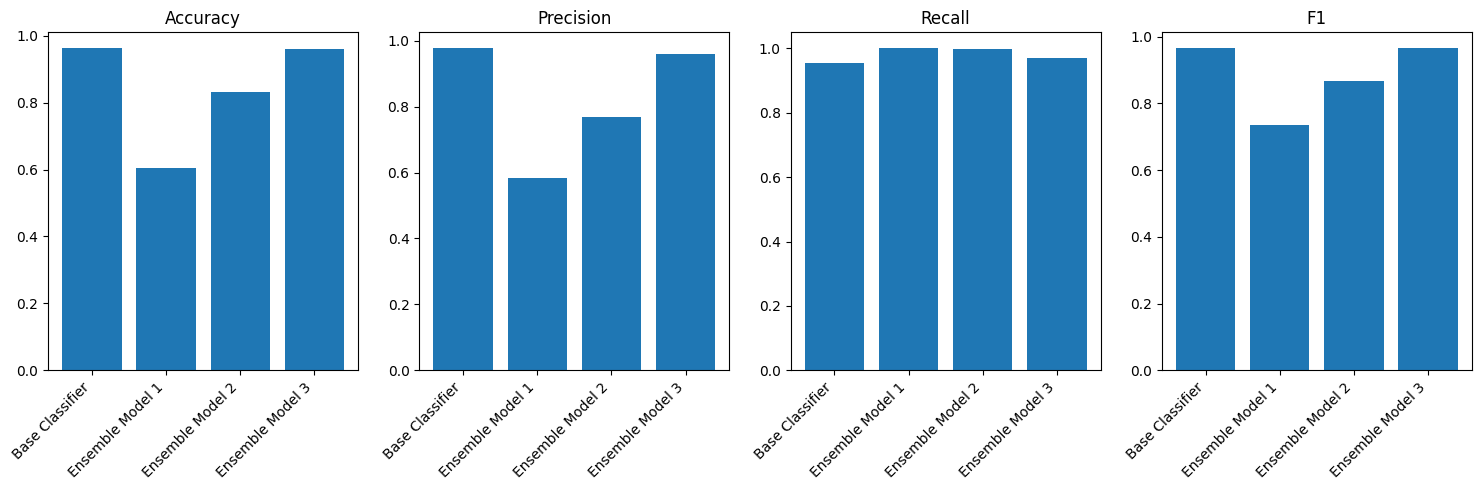

{'Base Classifier': {'accuracy': 0.9615873015873015, 'precision': 0.9761764705882353, 'recall': 0.953735632183908, 'f1': 0.9648255813953488}, 'Ensemble Model 1': {'accuracy': 0.6038095238095238, 'precision': 0.5823568798125209, 'recall': 0.9997126436781609, 'f1': 0.7359847683520203}, 'Ensemble Model 2': {'accuracy': 0.8322222222222222, 'precision': 0.7679716876797169, 'recall': 0.9977011494252873, 'f1': 0.8678915135608049}, 'Ensemble Model 3': {'accuracy': 0.9607936507936508, 'precision': 0.9591025276909969, 'recall': 0.9704022988505747, 'f1': 0.9647193258105985}}


In [14]:
results = compare_all_models_external(model)

# Print results
print(results)

Flowchart saved to c:\BA\SEM4\EDA\Wildfire classification\wildfire_flowchart.png


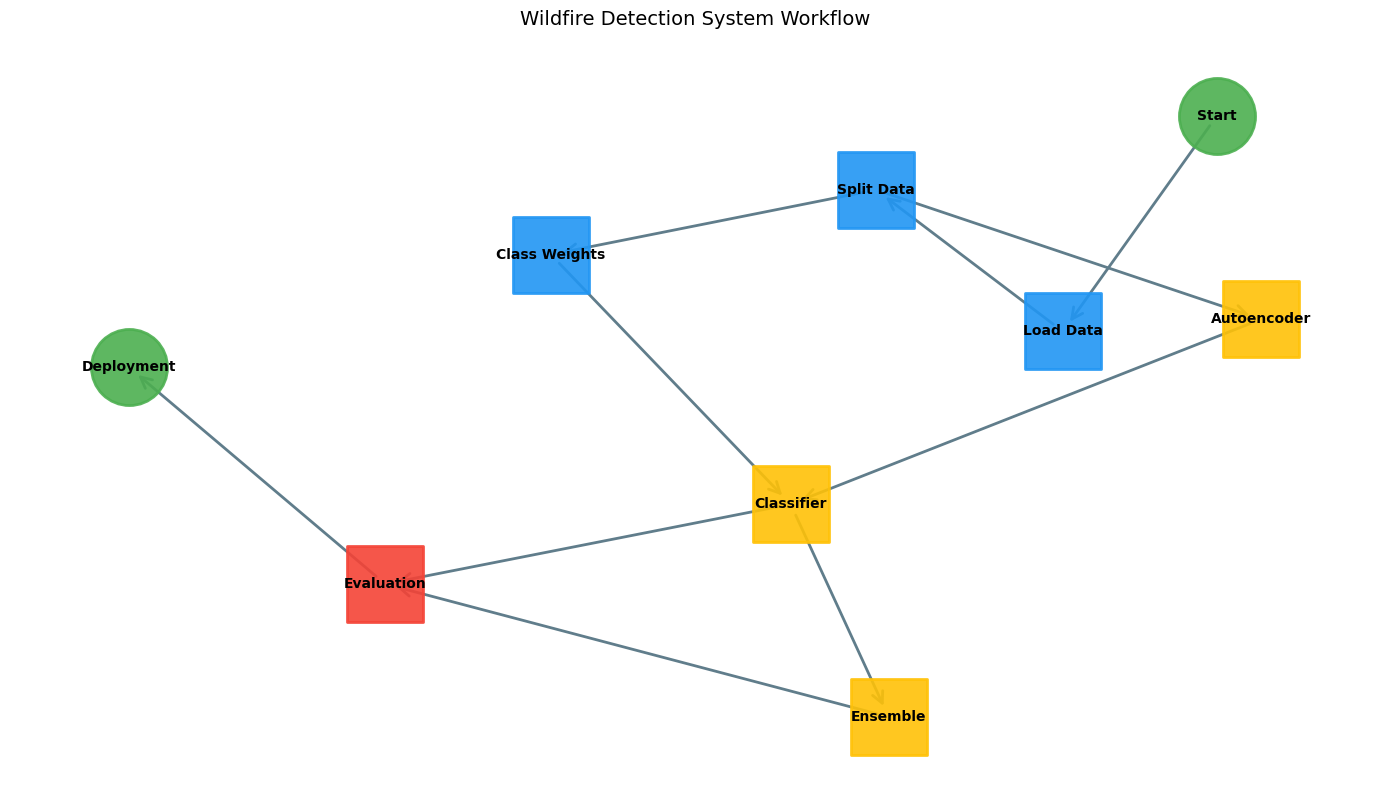

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import os

def draw_wildfire_flowchart(output_path='wildfire_flowchart.png'):
    """
    Draws a professional workflow flowchart using only NetworkX and Matplotlib
    without requiring Graphviz or PyGraphviz.
    
    Args:
        output_path (str): Path to save the flowchart image
    """
    # Create directed graph
    G = nx.DiGraph()
    
    # Define nodes with styles
    nodes = [
        ('Start', {'color': '#4CAF50', 'shape': 'ellipse'}),
        ('Load Data', {'color': '#2196F3', 'shape': 'box'}),
        ('Split Data', {'color': '#2196F3', 'shape': 'box'}),
        ('Class Weights', {'color': '#2196F3', 'shape': 'box'}),
        ('Autoencoder', {'color': '#FFC107', 'shape': 'box'}),
        ('Classifier', {'color': '#FFC107', 'shape': 'box'}),
        ('Ensemble', {'color': '#FFC107', 'shape': 'box'}),
        ('Evaluation', {'color': '#F44336', 'shape': 'box'}),
        ('Deployment', {'color': '#4CAF50', 'shape': 'ellipse'})
    ]
    G.add_nodes_from(nodes)
    
    # Define edges
    edges = [
        ('Start', 'Load Data'),
        ('Load Data', 'Split Data'),
        ('Split Data', 'Autoencoder'),
        ('Split Data', 'Class Weights'),
        ('Class Weights', 'Classifier'),
        ('Autoencoder', 'Classifier'),
        ('Classifier', 'Evaluation'),
        ('Classifier', 'Ensemble'),
        ('Ensemble', 'Evaluation'),
        ('Evaluation', 'Deployment')
    ]
    G.add_edges_from(edges)
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Use spring layout with custom parameters
    pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)
    
    # Draw nodes with different shapes and colors
    for node, data in G.nodes(data=True):
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=[node],
            node_size=3000,
            node_color=data['color'],
            node_shape='s' if data['shape'] == 'box' else 'o',
            alpha=0.9,
            linewidths=2
        )
    
    # Draw edges
    nx.draw_networkx_edges(
        G, pos,
        width=2,
        arrowsize=20,
        arrowstyle='->',
        edge_color='#607D8B'
    )
    
    # Draw labels
    nx.draw_networkx_labels(
        G, pos,
        font_size=10,
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Add title and adjust layout
    plt.title("Wildfire Detection System Workflow", fontsize=14, pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    # Save and show
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Flowchart saved to {os.path.abspath(output_path)}")
    plt.show()

# Example usage
if __name__ == "__main__":
    draw_wildfire_flowchart()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


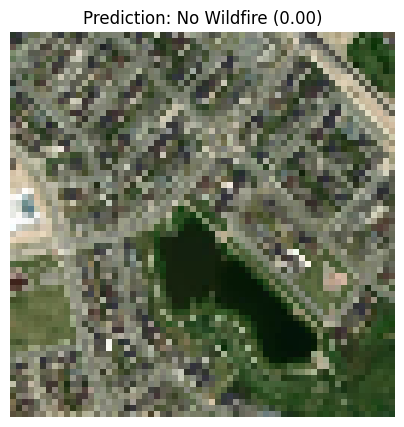

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


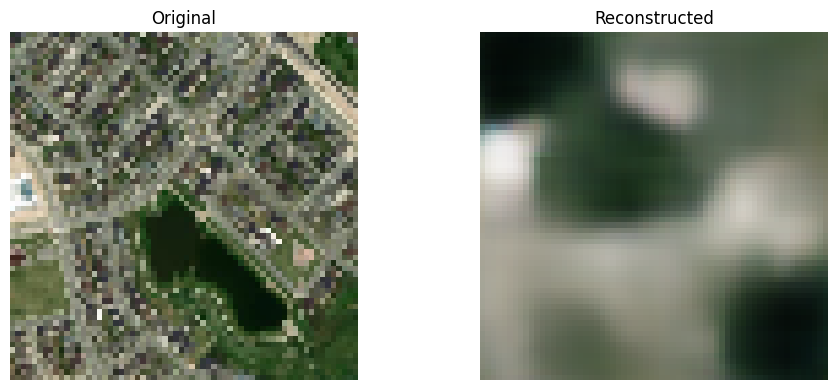

Wildfire probability: 0.0016


In [16]:
def predict_wildfire(model, image_path):
    """Make a prediction on a new image"""
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (model.img_size, model.img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    
    # Make prediction
    pred = model.classifier.predict(np.expand_dims(img, axis=0))[0][0]
    
    # Visualize image and prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Prediction: {'Wildfire' if pred > 0.5 else 'No Wildfire'} ({pred:.2f})")
    plt.axis('off')
    plt.show()
    
    # Get reconstruction
    reconst = model.autoencoder.predict(np.expand_dims(img, axis=0))[0]
    
    # Visualize original and reconstruction
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconst)
    plt.title("Reconstructed")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pred

# Example usage
test_image_path = r"C:\Users\shash\Downloads\archive\test\nowildfire\-79.72418,43.812973.jpg"
prediction = predict_wildfire(model, test_image_path)
print(f"Wildfire probability: {prediction:.4f}")